## Load Packages

In [1]:
using Dates, Roots

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

println4Ps (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Interest Rate vs (Zero Coupon) Bond Price

Recall: the bond price (for maturity $m$) is a function of the effective interest rate

$B(m) = [1+Y(m)]^{-m}$

and the inverse is $Y(m) = B(m)^{-1/m} - 1$.

Instead, with a continuously compounded interest rate we have 

$B(m) = e^{-m y(m)}$

and the inverse is $y(m) = -\ln B(m)/m$.

In [3]:
function BillPrice(Y,m)     #B as fn of Y        
    B = (1+Y)^(-m)
    return B
end
function EffRate(B,m)       #Y as fn of B      
    Y  = B^(-1/m) - 1       #effective interest rate
    return Y
end

function BillPrice2(y,m)    #B as fn of y         
    B = exp(-m*y)
    return B
end
function ContCompRate(B,m)  #y as fn of B      
    y  = -log(B)/m          #continuously compounded interest rate
    return y
end

ContCompRate (generic function with 1 method)

In [4]:
Y_range = 0:0.01:0.07             #consider different interest rates
B1      = BillPrice.(Y_range,1)        #1-year zero coupon bond 
B10     = BillPrice.(Y_range,10)       #10-year

println("let's plot it")

let's plot it


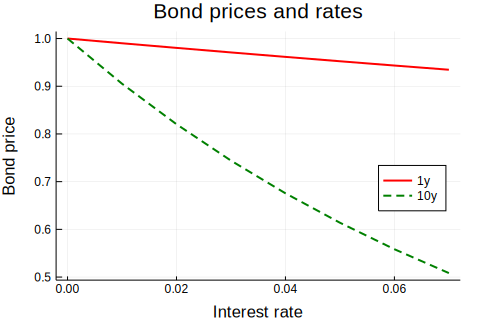

In [5]:
p1 = plot(Y_range,B1,color=:red,linewidth=2,label="1y")
plot!(Y_range,B10,color=:green,line=(:dash,2),label="10y",legend=:right)
title!("Bond prices and rates")
xlabel!("Interest rate")
ylabel!("Bond price")

In [6]:
m  = 0.5                              #maturity
B  = 0.95                             #bond price

Y = EffRate(B,m)                      #effective interest rate 
y = ContCompRate(B,m)                 #continuously compounded interest rate

printlnPs("Interest rates ($m-year bond with price $B)")
printlnPs("Effective and continuously compounded: ",[Y y])

Interest rates (0.5-year bond with price 0.95)
Effective and continuously compounded:      0.108     0.103


# Bond Returns (Zero Coupon Bonds)

Let $B_0$ denote the price of a bond in period $0$ and $B_1$ the price of the same bond one period later. (For simplicity, we skip the notation for maturity.)

The *log* return of holding this bond is $\ln (B_1/B_0)$

The cell below works with continuously compounded interest rates.

In [7]:
y₀ = 0.005                      #(continuously compounded) interest rate before
y₁ = 0.015                      #interest rate after  

B₀ = BillPrice2.(y₀,[1 10])     #bond prices (1-year and 10 year) before
B₁ = BillPrice2.(y₁,[1 10])     #bond prices (1-year and 10 year) after

R₁ = log.(B₁./B₀)                #return


xy       = vcat([y₀ y₀],B₀,[y₁ y₁],B₁,R₁)               #to table      
rowNames = ["Rate, t=0";"Bond price, t=0";"Rate, t=1";"Bond price, t=1";"Return"]
println("Analysis of two bonds: 1y and 10y maturity")
printTable(xy,["1y";"10y"],rowNames,15)

Analysis of two bonds: 1y and 10y maturity
                            1y            10y
Rate, t=0                0.005          0.005
Bond price, t=0          0.995          0.951
Rate, t=1                0.015          0.015
Bond price, t=1          0.985          0.861
Return                  -0.010         -0.100



# Forward Rates

From the forward-spot parity, the forward price of a bond (delivered in $m$ and maturing in $n$) is

$F=\left[  1+Y(m)\right]  ^{m}B(n)=B(n)/B(m)$.

A foward interest rate can then be defined as 

$\Gamma(m,n)  =F^{-1/(n-m)}-1$

In [8]:
function ForwardRate(Ym,m,Yn,n)           #forward rate, assuming n > m
    Bm = (1+Ym)^(-m) 
    Bn = (1+Yn)^(-n)
    F  = Bn/Bm
    Γ  = F^(-1/(n-m)) - 1
    return Γ
end

ForwardRate (generic function with 1 method)

In [9]:
m  = 0.5
n  = 0.75
Ym = 0.04
Yn = 0.05

Γ = ForwardRate(Ym,m,Yn,n)
printlnPs("\nImplied forward rate (from $m to $n years ahead): ",Γ)


Implied forward rate (from 0.5 to 0.75 years ahead):      0.070


# Coupon Bond Prices

Recall, the coupon bond price $P$ is the portfolio value of 

$P = \sum_{k=1}^{K} B(m_k)cf_k$,

where $cf_k$ is the cash flow in $m_k$ and $B(m_k)$ is the price of a zero-coupon bond maturing in $m_k$.

In [10]:
B  = [0.95,0.9]             #B(1),B(2)
c  = 0.06
cf = [c,1+c]            #cash flows in m=1 and 2

P = sum(B.*cf)

printlnPs("2y bond with $c coupon, zero-coupon prices are ",B')
printlnPs("Coupon bond price ",P)

2y bond with 0.06 coupon, zero-coupon prices are      0.950     0.900
Coupon bond price      1.011


The bond price can also be written

$P = \sum_{k=1}^{K} \frac{cf_{k}}{\left[  1+Y(m_{k})\right]  ^{m_{k}}}$

The ```BondPrice3(Y,cf,m)``` function below can handle both the case when $Y$ is a vector with different values for different maturities and when Y is a scalar (same interest rate for all maturities).

In [11]:
"""
Y:  scalar or K vector of interest rates
cf: scalar or K vector of cash flows
m: K vector of times for the cash flows
"""
function BondPrice3(Y,cf,m)              #cf is a vector of all cash flows at times m
    cdisc = cf./((Y.+1).^m)                #c/(1+y1)^m1, c/(1+y2)^m2 + ...
    P     = sum(cdisc)                     #price
    return P
end

BondPrice3

In [12]:
Y = [0.053;0.054]
c = 0.06
P =  BondPrice3(Y,[c;c+1],[1;2])
printlnPs("\n2y bond with $c coupon, spot rates are ",Y)
printlnPs("Coupon bond price: ",P)

Y = [0.06;0.091]
c = 0.09
P =  BondPrice3(Y,[c;c+1],[1;2])
printlnPs("\n2y bond with $c coupon, spot rates are ",Y)
printlnPs("Coupon bond price: ",P)


2y bond with 0.06 coupon, spot rates are      0.053     0.054
Coupon bond price:      1.011

2y bond with 0.09 coupon, spot rates are      0.060     0.091
Coupon bond price:      1.001


# Yield to Maturity

The yield to maturity is the $\theta$ that solves

$P = \sum_{k=1}^{K} \frac{cf_{k}}{(1+\theta)  ^{m_{k}}}$

We typically have to find $\theta$ by a numerical method.

In [13]:
c = 0.04                   #simple case  
Y = 0.03                   #all spot rates are 3%    

P = BondPrice3(Y,[c;c+1],[1;2])
ytm = find_zero(y->BondPrice3(y,[c;c+1],[1;2])-P,(-0.1,0.1))   #solving for ytm

printlnPs("Price of 2-year $c coupon bond when all spot rates are $Y: ",P)
printlnPs("ytm: ",ytm)

Price of 2-year 0.04 coupon bond when all spot rates are 0.03:      1.019
     ytm:      0.030


In [14]:
m  = [1;3]                #more advanced case, cash flow in year 1 and 3
Y  = [0.07;0.10]          #spot interest rates differ across maturities
cf = [1;1]       

P  = BondPrice3(Y,c,m)
ytm = find_zero(y->BondPrice3(y,c,m)-P,(-0.2,0.2))

printlnPs("ytm: ",ytm)

     ytm:      0.091


# Bootstrapping (extra)

Recall: with information about coupons $c(k)$ and coupon bond price $P(m)$, we solve for the implied zero coupon bond prices $B(s)$ from

$
\begin{bmatrix}
P(1)\\
P(2)
\end{bmatrix} =
\begin{bmatrix}
c(1)+1 & 0 \\
c(2) & c(2)+1
\end{bmatrix}
\begin{bmatrix}
B(1)\\
B(2)
\end{bmatrix}
$

In [15]:
c     = [0;0.06]
P     = [0.95;1.01]                 #coupon bond prices
m     = [1;2]                       #time of coupon payments
cfMat = [1    0   ;                 #cash flow matrix
         c[2] 1+c[2]]

println("The cash flow matrix")
printTable(cfMat,["mk=1";"mk=2"],["Bond 1";"Bond 2"])

println("B from solving P = cfMat*B (implied zero-coupon bond prices):")
B = cfMat\P
printmat(B)

Y = EffRate.(B,m)            #solve for the implied spot rates 
println("Implied spot interest rates:")
printmat(Y)

The cash flow matrix
            mk=1      mk=2
Bond 1     1.000     0.000
Bond 2     0.060     1.060

B from solving P = cfMat*B (implied zero-coupon bond prices):
     0.950
     0.899

Implied spot interest rates:
     0.053
     0.055



# Estimating Yield Curve with Regression Analysis (extra)

Recall: with a quadratic discount function

$B(m)=a_{0}+a_{1}m+a_{2}m^{2}$,

we can write the coupon bond price 

$P(m_{K})   =\sum_{k=1}^{K}B(m_{k})c+B(m_{K})$
as 

$P(m_{K})   =\sum_{k=1}^{K}(a_{0}+a_{1}m_{k}+a_{2}m_{k}^{2})c + 
(a_{0}+a_{1}m_{K}+a_{2}m_{K}^{2})$

Collect terms as 

$
P(m_{K})  =a_{0} (Kc+1) +
a_{1}(c \sum_{k=1}^{K} m_{k}+m_{K}) +
a_{2}(c \sum_{k=1}^{K} m_{k}^{2}+m_{K}^{2})$

We estimate $(a_0,a_1,a_2)$ by using the terms (within parentheses) as regressors.

In [16]:
n = length(P)
x = zeros(n,3)                      #create regressors for quadratic model: 3 columns
for i = 1:n                         #x[i,j] is for bond i, regressor j
    x[i,1] = m[i]*c[i] + 1
    x[i,2] = c[i]*sum(m[1]:m[i]) + m[i]
    x[i,3] = c[i]*sum((m[1]:m[i]).^2) + m[i]^2
end    

println("regressors:")
printTable(x,["term 0";"term 1";"term 2"],["Bond 1";"Bond 2"])

a = x\P                             #regress P on x
println("regression coefficients")
printmat(a)

m = 1:5
B = a[1] .+ a[2]*m + a[3]*m.^2      #fitted discount function

println("maturities    fitted B")
printmat([m B])

Y = EffRate.(B[1:2],m[1:2])         #solve for the implied spot rates 
println("maturities    fitted Y")
printmat([m[1:2] Y])

println("Btw. do B[4:5] make sense? If not, what does that teach us?")

regressors:
          term 0    term 1    term 2
Bond 1     1.000     1.000     1.000
Bond 2     1.120     2.180     4.300

regression coefficients
     0.693
     0.411
    -0.154

maturities    fitted B
     1.000     0.950
     2.000     0.899
     3.000     0.540
     4.000    -0.126
     5.000    -1.101

maturities    fitted Y
     1.000     0.053
     2.000     0.055

Btw. do B[4:5] make sense? If not, what does that teach us?
